### Hackathon 2: Optimisation of a Chemical Transformation with Bayesian Optimisation

#### Package Imports

In [5]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import plotly.graph_objs as go
from scipy.integrate import quad
from scipy.spatial.distance import cdist
from scipy.optimize import minimize, differential_evolution, NonlinearConstraint
from sklearn.decomposition import PCA
import math
import time
import sobol_seq
import torch
import gpytorch
import copy
import rdkit

### Attempt

In [6]:
reaction_yield = [-3.6, -3.9, -3.5, -3.3, -3.6, -3.0, -1.1, -0.7, -0.8, -0.6, -0.8, -1.2, -0.7, -1.5, -0.0, -0.0, -0.0, -0.5, -5.0, -0.0, -0.0, -1.6, -3.5, -6.6, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.5, -1.5, -0.0, -0.0, -0.0, -0.7, -0.0, -1.6, -0.0, -1.3, -2.2, -23.2, -0.0, -0.0, -0.0, -1.9, -4.0, -16.3, -4.0, -1.0, -0.0, -0.0, -0.0, -62.7, -0.4, -1.8, -1.7, -1.0, -0.0, -0.0, -0.1, -0.3, -0.3, -0.4, -0.4, -2.8, -1.1, -1.4, -2.6, -0.7, -1.4, -2.1, -10.9, -91.7, -100.0, -50.2, -27.8, -79.1, -0.0, -3.1, -0.0, -1.2, -1.8, -14.5, -0.5, -0.5, -0.0, -0.4, -0.6, -7.8, -3.1, -3.5, -3.2, -2.2, -3.0, -15.8]
exp_time = 0

def experiment_yield(condition , X_searchspace):
    return(reaction_yield[X_searchspace.index(condition)])

/var/tmp/pbs.488753.pbs-7/ipykernel_365156/41528406.py:126: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/tmp/pbs.488753.pbs-7/ipykernel_365156/41528406.py:127: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(0, sf2opt - np.matmul(np.matmul(k.T,invK),k))


Iteration 0 complete.
Iteration 1 complete.
Iteration 2 complete.
Iteration 3 complete.
Iteration 4 complete.
Iteration 5 complete.
Iteration 6 complete.
Iteration 7 complete.
Iteration 8 complete.
Iteration 9 complete.


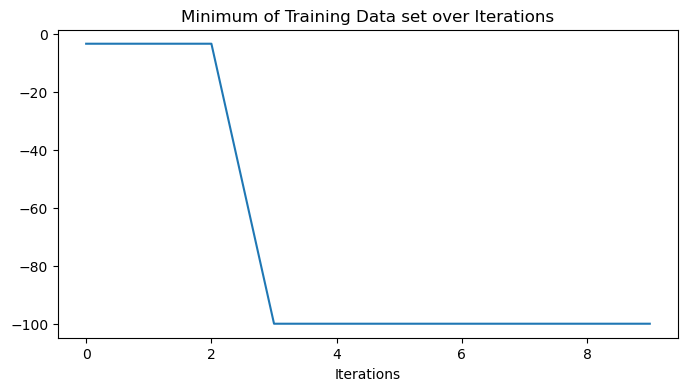

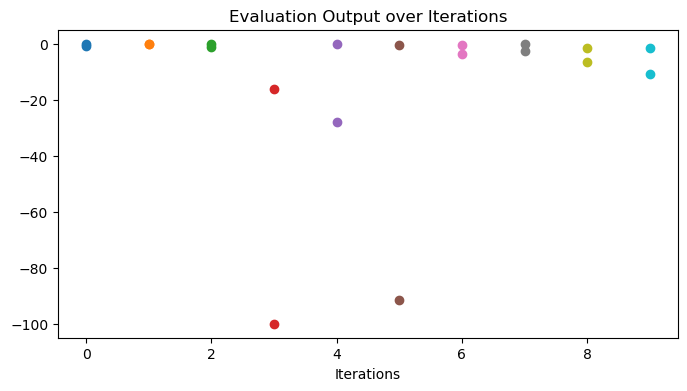

In [14]:
class GP_model_meanzero:

    def __init__(self, X, Y, kernel, hyperparams_multistart_loops):
        self.X, self.Y, self.kernel = X, Y, kernel
        self.number_of_point, self.nx_dimensions, self.ny_dimensions = X.shape[0], X.shape[1], Y.shape[1]
        self.multistart_loops            = hyperparams_multistart_loops

        #Normalisation
        self.X_mean, self.X_std     = np.mean(X, axis=0), np.std(X, axis=0)
        self.Y_mean, self.Y_std     = np.mean(Y, axis=0), np.std(Y, axis=0)
        self.X_norm, self.Y_norm    = (X-self.X_mean)/self.X_std, (Y-self.Y_mean)/self.Y_std

        #Determine Kernel Hyperparameters 
        self.hyperparam_optimized , self.inverse_covariance_matrix_opt   = self.determine_hyperparameters()     
        
    def Cov_mat(self, kernel, X_norm, W, sf2):
        if kernel == 'SquaredExponential':
            xixj_euclidean_distance = cdist(X_norm, X_norm, 'seuclidean', V=W)**2 
            cov_matrix = sf2*np.exp(-0.5*xixj_euclidean_distance)
            return (cov_matrix)
        else:
            print('ERROR no kernel with name ', kernel)


    def negative_loglikelihood(self, hyper, X, Y):
        # internal parameters
        n_point, nx_dim = self.number_of_point, self.nx_dimensions
        kernel          = self.kernel
         
        W               = np.exp(2*hyper[:nx_dim])   # W <=> 1/lambda
        sf2             = np.exp(2*hyper[nx_dim])    # variance of the signal 
        sn2             = np.exp(2*hyper[nx_dim+1])  # variance of noise

        # obtaining negative logliklihood via Cholesky decomposition 
        K       = self.Cov_mat(kernel, X, W, sf2)  
        K       = K + (sn2 + 1e-8)*np.eye(n_point) 
        K       = (K + K.T)*0.5                   
        L       = np.linalg.cholesky(K)            
        logdetK = 2 * np.sum(np.log(np.diag(L)))   
        invLY   = np.linalg.solve(L,Y)             
        alpha   = np.linalg.solve(L.T,invLY)       
        NLL     = np.dot(Y.T,alpha) + logdetK     
        return (NLL)

    
    def determine_hyperparameters(self): 
        # setting up bounds for the log likelyhood minimsation
        lower_bound = np.array([-4.]*(self.nx_dimensions+1) + [-8.])  # lengthscales + signal variance, noise variance
        upper_bound = np.array([4.]*(self.nx_dimensions+1) + [ -2.]) 
        bounds      = np.hstack((lower_bound.reshape(self.nx_dimensions+2,1), upper_bound.reshape(self.nx_dimensions+2,1)))

        #gives number of input set of random starting guesses for each hyperparameter
        multi_startvec         = sobol_seq.i4_sobol_generate(self.nx_dimensions + 2, self.multistart_loops)
        
        #variables for storing information during loop
        temp_min_hyperparams   = [0.]*self.multistart_loops
        temp_loglikelihood     = np.zeros((self.multistart_loops))
        hyperparam_optimized   = np.zeros((self.nx_dimensions+2, self.ny_dimensions)) #for best solutions
        inverse_covariance_matrix_opt = []
        
        #minimisation of hyperparameters
        for i in range(self.ny_dimensions):
            for j in range(self.multistart_loops ):
                #initilising hyperparam guess
                hyperparams_initialisation   = lower_bound + (upper_bound-lower_bound)*multi_startvec[j,:] # mapping sobol unit cube to boudns
               
                result = minimize(self.negative_loglikelihood,
                               hyperparams_initialisation,
                               args=(self.X_norm, self.Y_norm[:,i]),
                               method='SLSQP',
                               options={'disp':False,'maxiter':10000},
                               bounds=bounds,
                               tol=1e-12)
                
                temp_min_hyperparams[j] = result.x
                temp_loglikelihood[j]   = result.fun  

            # choosing best solution from temporary lists
            minimumloglikelihood_index    = np.argmin(temp_loglikelihood)
            hyperparam_optimized[:,i]     = temp_min_hyperparams[minimumloglikelihood_index  ]
    
            # exponential to recover value from log space
            lengthscale_opt         = np.exp(2.*hyperparam_optimized[:self.nx_dimensions,i])
            signalvarience_opt      = np.exp(2.*hyperparam_optimized[self.nx_dimensions,i])
            noise_opt               = np.exp(2.*hyperparam_optimized[self.nx_dimensions+1,i]) + 1e-8
    
            #obtain convarience matrix from optimised kernel hyper parameters
            covarience_matrix_opt              = self.Cov_mat(self.kernel, self.X_norm, lengthscale_opt,signalvarience_opt) + noise_opt*np.eye(self.number_of_point)
            self.covarience_matrix_opt         = covarience_matrix_opt
            inverse_covariance_matrix_opt     += [np.linalg.solve(covarience_matrix_opt, np.eye(self.number_of_point))]
            
        return (hyperparam_optimized , inverse_covariance_matrix_opt)

    def calc_cov_sample(self,xnorm,Xnorm,ell,sf2):
        # internal parameters
        nx_dim = self.nx_dimensions

        #covariance of sample
        dist = cdist(Xnorm, xnorm.reshape(1,nx_dim), 'seuclidean', V=ell)**2
        cov_matrix = sf2 * np.exp(-.5*dist)
        return (cov_matrix )         


    def GP_inference_np(self, x):
        nx_dim                   = self.nx_dimensions
        kernel, ny_dim           = self.kernel, self.ny_dimensions
        hypopt, Cov_mat          = self.hyperparam_optimized, self.Cov_mat
        stdX, stdY, meanX, meanY = self.X_std, self.Y_std, self.X_mean, self.Y_mean
        calc_cov_sample          = self.calc_cov_sample
        invKsample               = self.inverse_covariance_matrix_opt
        Xsample, Ysample         = self.X_norm, self.Y_norm

        xnorm = (x - meanX)/stdX
        mean  = np.zeros(ny_dim)
        var   = np.zeros(ny_dim)
        
        # ny_dim -> number of outputs
        for i in range(ny_dim):
            invK           = invKsample[i]
            hyper          = hypopt[:,i]
            ellopt, sf2opt = np.exp(2*hyper[:nx_dim]), np.exp(2*hyper[nx_dim])

            # calculation of covaraince for each output
            # although noise hyperparameter determiend, it is ignored here for better visualisation
            k       = calc_cov_sample(xnorm,Xsample,ellopt,sf2opt)
            mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
            var[i]  = max(0, sf2opt - np.matmul(np.matmul(k.T,invK),k)) 

        # un-normalisation (obtianing actual mean and variance) 
        mean_sample = mean*stdY + meanY
        var_sample  = var*stdY**2
        
        return (mean_sample, var_sample)



class BO_multiD_batch_chemistry: 
    def __init__(self, X, kernel, X_searchspace, iterations,acquisition_function, objective_func,print_graph, acquisition_hyperparam, batch, experiment_time = 0):

        self.X = np.array(X)
        Fx_training = np.array([objective_func(x.tolist(),X_searchspace) for x in self.X])
        self.Y = Fx_training.reshape(-1, 1)
        
        self.minY = []
        self.exploredY = []

        for i in range(iterations):
            GP_m = GP_model_meanzero(self.X, self.Y, kernel, hyperparams_multistart_loops=3)

            means = np.zeros(len(X_searchspace))
            varience  = np.zeros(len(X_searchspace))
            for idx, xx in enumerate(X_searchspace):
                m, v = GP_m.GP_inference_np(xx)
                means[idx] = m.item()
                varience[idx]  = v.item()

            
            if acquisition_function == 'ThompsonMarginal':
                new_X = []
                for number in range(batch): 
                    ts_sample  = means + acquisition_hyperparam[0]*np.sqrt(varience)*np.random.randn(len(X_searchspace))
                    new_X.append(X_searchspace[np.argmin(ts_sample)])
                new_X = np.array(new_X)
            else: 
                print('No acquisition function named', acquisition_function)

            time.sleep(experiment_time)
            new_Y = np.array([objective_func(x.tolist(),X_searchspace) for x in new_X]).reshape(-1, 1)
            self.X = np.vstack([self.X, new_X])
            self.Y = np.vstack([self.Y, new_Y])

            self.minY     += [self.Y.min()]
            self.exploredY += [new_Y.flatten().tolist()]

            if print_graph:
                print(f"Iteration {i} complete.")

        plt.figure(figsize=(8,4), dpi=100)
        plt.title('Minimum of Training Data set over Iterations')
        plt.xlabel('Iterations')
        plt.plot(range(iterations), self.minY)
        plt.show()

        plt.figure(figsize=(8,4), dpi=100)
        plt.title('Evaluation Output over Iterations')
        plt.xlabel('Iterations')
        for i, vals in enumerate(self.exploredY):
            plt.scatter([i]*batch, vals)
        plt.show()

precatalyst_descriptors = [['G3_BINAP',[622.20]],
                           ['G3_DPPF',[544.10]],
                           ['G2_XantPhos',[578.19]],
                           ['G2_tertBu3P',[202.19]],
                           ['G3_PPA',[292.12]],
                           ['G3_Aphos',[265.20]],
                           ['G3_Xphos',[476.36]],
                           ['G2_RuPhos',[466.30]],
                           ['G3_DTBPF',[474.23]],
                           ['G3_J009',[554.29]],
                           ['G3_MorDalPhos',[463.30]],
                           ['G3_BrettPhos',[536.38]],
                           ['G3_tertBuXPhos',[424.33]],
                           ['G3_tertBuBrettPhos',[484.35]],
                           ['G3_RockPhos',[468.35]],
                           ['G3_AdBrettPhos',[640.44]]]

base_descriptors = [['DBU', [24.3]],
                    ['MTBD', [25.5]],
                    ['BTMG', [23.6]],
                    ['BEMP', [27.6]],
                    ['BTTP', [28.4]],
                    ['P2Et', [32.9]]]

reaction_yield = [-3.6, -3.9, -3.5, -3.3, -3.6, -3.0, -1.1, -0.7, -0.8, -0.6, -0.8, -1.2, -0.7, -1.5, -0.0, -0.0, -0.0, -0.5, -5.0, -0.0, -0.0, -1.6, -3.5, -6.6, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.5, -1.5, -0.0, -0.0, -0.0, -0.7, -0.0, -1.6, -0.0, -1.3, -2.2, -23.2, -0.0, -0.0, -0.0, -1.9, -4.0, -16.3, -4.0, -1.0, -0.0, -0.0, -0.0, -62.7, -0.4, -1.8, -1.7, -1.0, -0.0, -0.0, -0.1, -0.3, -0.3, -0.4, -0.4, -2.8, -1.1, -1.4, -2.6, -0.7, -1.4, -2.1, -10.9, -91.7, -100.0, -50.2, -27.8, -79.1, -0.0, -3.1, -0.0, -1.2, -1.8, -14.5, -0.5, -0.5, -0.0, -0.4, -0.6, -7.8, -3.1, -3.5, -3.2, -2.2, -3.0, -15.8]

def experiment_yield(condition , X_searchspace):
    return(reaction_yield[X_searchspace.index(condition)])

X_training = [[544.1, 32.9],[265.2, 24.3],[640.44, 25.5]]
X_searchspace = []
for precat in precatalyst_descriptors:
    for base in base_descriptors:
        X_searchspace += [precat[1]+base[1]]

BO_m = BO_multiD_batch_chemistry(X = X_training,  
   kernel = 'SquaredExponential', 
   X_searchspace = X_searchspace, 
   iterations = 10, 
   acquisition_function = 'ThompsonMarginal', 
   objective_func = experiment_yield, 
   print_graph = True, 
   acquisition_hyperparam=[3], 
   batch = 2, 
   experiment_time=exp_time)